In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/msu-nlp/train_translated_full.csv")

df[["question", "answer_text"]].head(20)


,question,answer_text
0,When did Beyonce start becoming popular?,in the late 1990s
1,What areas did Beyonce compete in when she was...,singing and dancing
2,When did Beyonce leave Destiny's Child and bec...,2003
3,In what city and state did Beyonce grow up?,"Houston, Texas"
4,In which decade did Beyonce become famous?,late 1990s
5,In what R&B group was she the lead singer?,Destiny's Child
6,What album made her a worldwide known artist?,Dangerously in Love
7,Who managed the Destiny's Child group?,Mathew Knowles
8,When did Beyoncé rise to fame?,late 1990s
9,What role did Beyoncé have in Destiny's Child?,lead singer


In [4]:
!pip install transformers sentencepiece


In [7]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

model_name = "facebook/nllb-200-distilled-600M"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

In [8]:
def translate_to_hi(text):
    if not isinstance(text, str) or text.strip() == "":
        return ""

    # Encode
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)

    # Hindi language token
    hi_token_id = tokenizer.convert_tokens_to_ids("hi_Deva")

    # Generate translation
    with torch.no_grad():
        generated_tokens = model.generate(
            **inputs,
            forced_bos_token_id=hi_token_id
        )

    return tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)[0]


In [11]:
train = pd.read_csv("/content/drive/MyDrive/msu-nlp/train_translated_full.csv")
train.head()


,title,context,question,answer_text,context_hi,question_hi
0,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,in the late 1990s,बेयॉन्से गिज़ेल नॉल्स-कार्टर (/biːˈjɒnseɪ/ bee...,बेयोंस कब से लोकप्रिय हो रही है?
1,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,singing and dancing,बेयॉन्से गिज़ेल नॉल्स-कार्टर (/biːˈjɒnseɪ/ bee...,जब वह बड़ी थी तो बेयोंस किस क्षेत्र में प्रतिस...
2,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,2003,बेयॉन्से गिज़ेल नॉल्स-कार्टर (/biːˈjɒnseɪ/ bee...,बेयोंस ने डेस्टिनी चाइल्ड को कब छोड़ दिया और ए...
3,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"Houston, Texas",बेयॉन्से गिज़ेल नॉल्स-कार्टर (/biːˈjɒnseɪ/ bee...,बेयोन्से किस शहर और राज्य में बड़ी हुई थी?
4,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,late 1990s,बेयॉन्से गिज़ेल नॉल्स-कार्टर (/biːˈjɒnseɪ/ bee...,बेयोंस किस दशक में प्रसिद्ध हुई?


In [15]:
!pip install transformers sentencepiece accelerate -q

import pandas as pd
import torch
from transformers import MarianTokenizer, MarianMTModel
from tqdm import tqdm

# Load datasets
train = pd.read_csv("/content/drive/MyDrive/msu-nlp/train_translated_full.csv")
dev   = pd.read_csv("/content/drive/MyDrive/msu-nlp/dev_translated_full.csv")

# Load EN → HI translation model
model_name = "Helsinki-NLP/opus-mt-en-hi"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name).to("cuda")

# -----------------------------------------
# 🚀 STEP 1 — Extract UNIQUE answers only
# -----------------------------------------
all_answers = pd.concat([train["answer_text"], dev["answer_text"]], ignore_index=True)
unique_answers = list(all_answers.dropna().unique())

print("Unique answers:", len(unique_answers))

# -----------------------------------------
# 🚀 STEP 2 — Batch translation on GPU
# -----------------------------------------
def batch_translate(texts, batch_size=64):
    outputs = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Batch Translating"):
        batch = texts[i:i+batch_size]
        tokenized = tokenizer(batch, return_tensors="pt", padding=True, truncation=True).to("cuda")
        with torch.no_grad():
            translated = model.generate(**tokenized, max_length=40)
        decoded = tokenizer.batch_decode(translated, skip_special_tokens=True)
        outputs.extend(decoded)
    return outputs

# Perform fast batch translation
translated_list = batch_translate(unique_answers, batch_size=64)

# Make a mapping: English → Hindi
translated_dict = {eng: hin for eng, hin in zip(unique_answers, translated_list)}

# -----------------------------------------
# 🚀 STEP 3 — Assign translations back
# -----------------------------------------
train["answer_text_hi"] = train["answer_text"].map(translated_dict)
dev["answer_text_hi"]   = dev["answer_text"].map(translated_dict)

# -----------------------------------------
# 🚀 STEP 4 — Save translated datasets
# -----------------------------------------
train_out = "/content/drive/MyDrive/msu-nlp/train_translated_full_with_hi_answers.csv"
dev_out   = "/content/drive/MyDrive/msu-nlp/dev_translated_full_with_hi_answers.csv"

train.to_csv(train_out, index=False)
dev.to_csv(dev_out, index=False)

print("🔥 DONE — Batch translation finished FAST!")
print(train_out)
print(dev_out)


/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


Unique answers: 69003


Batch Translating: 100%|██████████| 1079/1079 [12:43<00:00,  1.41it/s]


🔥 DONE — Batch translation finished FAST!
/content/drive/MyDrive/msu-nlp/train_translated_full_with_hi_answers.csv
/content/drive/MyDrive/msu-nlp/dev_translated_full_with_hi_answers.csv


In [16]:
train[["answer_text", "answer_text_hi"]].head()

,answer_text,answer_text_hi
0,in the late 1990s,१९९० के आखिर में
1,singing and dancing,गाना और नृत्य
2,2003,2003
3,"Houston, Texas","हबल्टन, टेक्सास"
4,late 1990s,१९९० के आखिर में


In [17]:
dev[["answer_text", "answer_text_hi"]].head()

,answer_text,answer_text_hi
0,France,फ्रांस
1,10th and 11th centuries,10वां और 11वीं शताब्दियों
2,"Denmark, Iceland and Norway","डेनमार्क, आयरलैंड और नॉर्वे"
3,Rollo,पाँसा फेंकें
4,10th century,10वीं सदी


In [18]:
!pip install transformers datasets evaluate sentencepiece accelerate -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.9 MB/s eta 0:00:00


In [19]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

train_path = "/content/drive/MyDrive/msu-nlp/train_translated_full_with_hi_answers.csv"
dev_path   = "/content/drive/MyDrive/msu-nlp/dev_translated_full_with_hi_answers.csv"

train = pd.read_csv(train_path)
dev   = pd.read_csv(dev_path)

train.head()
dev.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,title,context,question,answer_text,context_hi,question_hi,answer_text_hi
0,Normans,The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,France,नॉर्मन (नॉर्मनः Nourmands; फ्रेंचः Normands; ल...,नॉरमैंडी किस देश में स्थित है?,फ्रांस
1,Normans,The Normans (Norman: Nourmands; French: Norman...,When were the Normans in Normandy?,10th and 11th centuries,नॉर्मन (नॉर्मनः Nourmands; फ्रेंचः Normands; ल...,नॉर्मन नॉरमैंडी में कब थे?,10वां और 11वीं शताब्दियों
2,Normans,The Normans (Norman: Nourmands; French: Norman...,From which countries did the Norse originate?,"Denmark, Iceland and Norway",नॉर्मन (नॉर्मनः Nourmands; फ्रेंचः Normands; ल...,नॉर्डिक किस देश से आते हैं?,"डेनमार्क, आयरलैंड और नॉर्वे"
3,Normans,The Normans (Norman: Nourmands; French: Norman...,Who was the Norse leader?,Rollo,नॉर्मन (नॉर्मनः Nourmands; फ्रेंचः Normands; ल...,नॉर्डिक नेता कौन था?,पाँसा फेंकें
4,Normans,The Normans (Norman: Nourmands; French: Norman...,What century did the Normans first gain their ...,10th century,नॉर्मन (नॉर्मनः Nourmands; फ्रेंचः Normands; ल...,किस सदी में नॉर्मनों ने पहली बार अपनी अलग पहचा...,10वीं सदी


In [24]:
!pip install fugashi python-Levenshtein rapidfuzz -q
from rapidfuzz import fuzz, process
import re
import unicodedata
import json
from tqdm import tqdm
import pandas as pd


# -------------------------------------------------------
# NORMALIZATION UTILITIES
# -------------------------------------------------------

def normalize_text(txt):
    if not isinstance(txt, str):
        return ""
    txt = unicodedata.normalize("NFKC", txt)
    txt = txt.replace("।", " ")
    txt = re.sub(r"[^\w\s\u0900-\u097F]", " ", txt)   # keep Devanagari + whitespace
    txt = re.sub(r"\s+", " ", txt).strip()
    return txt


def strip_postpositions(txt):
    """Remove common Hindi suffixes that appear after locations/numbers."""
    for p in ["में", "का", "की", "के", "से", "को", "द्वारा"]:
        if txt.endswith(" " + p):
            return txt[: -len(p) - 1]
    return txt


# -------------------------------------------------------
# SMART MATCHER (3-PASS STRATEGY)
# -------------------------------------------------------

def find_best_answer_start(context, answer):
    """
    Returns best answer_start index using:
    1) Exact match
    2) Normalized match
    3) Fuzzy token-level matching
    """

    # PASS 1 — Exact match
    exact = context.find(answer)
    if exact != -1:
        return exact

    # Prepare normalized versions
    context_norm = normalize_text(context)
    answer_norm  = normalize_text(answer)
    answer_norm  = strip_postpositions(answer_norm)

    # PASS 2 — Normalized exact match
    exact_norm = context_norm.find(answer_norm)
    if exact_norm != -1:
        return exact_norm

    # PASS 3 — Fuzzy matching (per-token)
    tokens = answer_norm.split()
    best_score = -1
    best_index = -1

    for token in tokens:
        if len(token) < 2:
            continue

        # Search token in context_tokens via fuzzy matching
        matches = process.extract(token, context_norm.split(), scorer=fuzz.partial_ratio, limit=3)

        for match_text, score, match_index in matches:
            if score > best_score and score > 70:  # threshold
                # reconstruct approx character index
                approx_start = context_norm.find(match_text)
                if approx_start != -1:
                    best_score = score
                    best_index = approx_start

    return best_index


# -------------------------------------------------------
# NEW BUILD FUNCTION USING FUZZY MATCHING
# -------------------------------------------------------

def build_squad_json_fuzzy(df, out_path):
    df = df.fillna("")

    out = {"data": []}
    paragraphs = {}

    skipped_missing = 0
    unmatched = 0
    matched = 0

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Building fuzzy SQuAD"):

        title = row["title"]
        context = row["context_hi"]
        question = row["question_hi"]
        answer = row["answer_text_hi"]

        if not isinstance(context, str) or not isinstance(question, str) or not isinstance(answer, str):
            skipped_missing += 1
            continue

        if context.strip() == "" or question.strip() == "" or answer.strip() == "":
            skipped_missing += 1
            continue

        # Create entry for this title/context
        if title not in paragraphs:
            paragraphs[title] = {}
        if context not in paragraphs[title]:
            paragraphs[title][context] = {
                "context": context,
                "qas": []
            }

        # Fuzzy matching for answer start
        answer_start = find_best_answer_start(context, answer)

        if answer_start == -1:
            unmatched += 1
            continue

        matched += 1

        qas_item = {
            "id": f"{title}-{idx}",
            "question": question,
            "answers": [{
                "text": answer,
                "answer_start": answer_start
            }]
        }

        paragraphs[title][context]["qas"].append(qas_item)

    # Convert to SQuAD format
    for title, contexts in paragraphs.items():
        out["data"].append({
            "title": title,
            "paragraphs": list(contexts.values())
        })

    # Save
    with open(out_path, "w", encoding="utf-8") as f:
        json.dump(out, f, ensure_ascii=False, indent=2)

    print("\nSaved:", out_path)
    print("Matched:", matched)
    print("Unmatched:", unmatched)
    print("Missing:", skipped_missing)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 694.9/694.9 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 84.3 MB/s eta 0:00:00


In [25]:
build_squad_json_fuzzy(train, "/content/train_hi_squad_fuzzy.json")
build_squad_json_fuzzy(dev,   "/content/dev_hi_squad_fuzzy.json")

Building fuzzy SQuAD: 100%|██████████| 130319/130319 [02:07<00:00, 1020.53it/s]



Saved: /content/train_hi_squad_fuzzy.json
Matched: 77016
Unmatched: 9802
Missing: 43501


Building fuzzy SQuAD: 100%|██████████| 11873/11873 [00:05<00:00, 2072.41it/s]



Saved: /content/dev_hi_squad_fuzzy.json
Matched: 5283
Unmatched: 644
Missing: 5946


In [26]:
!pip install transformers datasets evaluate sentencepiece accelerate -q

import json, collections
import numpy as np
from tqdm import tqdm
from datasets import Dataset
import evaluate
from transformers import (
    AutoTokenizer,
    AutoModelForQuestionAnswering,
    TrainingArguments,
    Trainer
)

In [27]:
train_json_path = "/content/train_hi_squad_fuzzy.json"
dev_json_path   = "/content/dev_hi_squad_fuzzy.json"

def load_and_flatten_squad(path):
    with open(path, "r", encoding="utf-8") as f:
        squad = json.load(f)

    rows = []
    for article in squad["data"]:
        title = article.get("title", "")
        for para in article["paragraphs"]:
            context = para["context"]
            for qa in para["qas"]:
                rows.append({
                    "id": qa["id"],
                    "title": title,
                    "context": context,
                    "question": qa["question"],
                    "answers": {
                        "text": [qa["answers"][0]["text"]],
                        "answer_start": [qa["answers"][0]["answer_start"]]
                    }
                })
    return Dataset.from_list(rows)

train_ds = load_and_flatten_squad(train_json_path)
dev_ds   = load_and_flatten_squad(dev_json_path)

print(train_ds)
print(dev_ds)


Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 77016
})
Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 5283
})


In [29]:
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

max_length = 384
stride = 128

def clean_examples(examples):
    valid_mask = [
        (q is not None and isinstance(q, str) and q.strip() != "") and
        (c is not None and isinstance(c, str) and c.strip() != "")
        for q, c in zip(examples["question"], examples["context"])
    ]
    for key in examples.keys():
        examples[key] = [v for v, ok in zip(examples[key], valid_mask) if ok]
    return examples


def prepare_train_features(examples):
    examples = clean_examples(examples)

    questions = [q.lstrip() for q in examples["question"]]

    tokenized = tokenizer(
        questions,
        examples["context"],
        truncation=True,
        max_length=max_length,
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        return_token_type_ids=False,
        padding="max_length",
    )

    sample_mapping = tokenized.pop("overflow_to_sample_mapping")
    offset_mapping = tokenized.pop("offset_mapping")

    start_positions = []
    end_positions = []

    for i, offsets in enumerate(offset_mapping):

        input_ids = tokenized["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)
        sequence_ids = tokenized.sequence_ids(i)

        sample_idx = sample_mapping[i]
        answers = examples["answers"][sample_idx]
        start_char = answers["answer_start"][0]
        end_char = start_char + len(answers["text"][0])

        # Find start of context
        token_start_index = 0
        while sequence_ids[token_start_index] != 1:
            token_start_index += 1

        # End of context
        token_end_index = len(input_ids) - 1
        while sequence_ids[token_end_index] != 1:
            token_end_index -= 1

        if not (
            offsets[token_start_index][0] <= start_char and
            offsets[token_end_index][1] >= end_char
        ):
            start_positions.append(cls_index)
            end_positions.append(cls_index)
        else:
            while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                token_start_index += 1
            start_positions.append(token_start_index - 1)

            while offsets[token_end_index][1] >= end_char:
                token_end_index -= 1
            end_positions.append(token_end_index + 1)

    tokenized["start_positions"] = start_positions
    tokenized["end_positions"] = end_positions
    return tokenized


def prepare_validation_features(examples):
    examples = clean_examples(examples)

    questions = [q.lstrip() for q in examples["question"]]

    tokenized = tokenizer(
        questions,
        examples["context"],
        truncation=True,
        max_length=max_length,
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        return_token_type_ids=False,
        padding="max_length",
    )

    sample_mapping = tokenized.pop("overflow_to_sample_mapping")
    tokenized["example_id"] = []

    for i in range(len(tokenized["input_ids"])):
        sample_idx = sample_mapping[i]
        tokenized["example_id"].append(examples["id"][sample_idx])

        sequence_ids = tokenized.sequence_ids(i)
        offsets = tokenized["offset_mapping"][i]

        tokenized["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None
            for k, o in enumerate(offsets)
        ]

    return tokenized

train_feats = train_ds.map(
    prepare_train_features,
    batched=True,
    remove_columns=train_ds.column_names
)

dev_feats = dev_ds.map(
    prepare_validation_features,
    batched=True,
    remove_columns=dev_ds.column_names
)


Map:   0%|          | 0/77016 [00:00<?, ? examples/s]

Map:   0%|          | 0/5283 [00:00<?, ? examples/s]

In [30]:
#Post-process predictions + compute EM/F1
squad_metric = evaluate.load("squad")

def postprocess_qa_predictions(examples, features, raw_predictions, n_best_size=20, max_answer_length=30):
    all_start_logits, all_end_logits = raw_predictions

    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, f in enumerate(features):
        features_per_example[example_id_to_index[f["example_id"]]].append(i)

    predictions = collections.OrderedDict()

    for example_index, example in enumerate(examples):
        feature_indices = features_per_example[example_index]
        context = example["context"]

        valid_answers = []

        for fi in feature_indices:
            start_logits = all_start_logits[fi]
            end_logits = all_end_logits[fi]
            offsets = features[fi]["offset_mapping"]

            start_indexes = np.argsort(start_logits)[-n_best_size:][::-1]
            end_indexes = np.argsort(end_logits)[-n_best_size:][::-1]

            for s in start_indexes:
                for e in end_indexes:
                    if offsets[s] is None or offsets[e] is None:
                        continue
                    if e < s or (e - s + 1) > max_answer_length:
                        continue

                    start_char = offsets[s][0]
                    end_char = offsets[e][1]
                    valid_answers.append({
                        "score": start_logits[s] + end_logits[e],
                        "text": context[start_char:end_char]
                    })

        if valid_answers:
            best = max(valid_answers, key=lambda x: x["score"])
            predictions[example["id"]] = best["text"]
        else:
            predictions[example["id"]] = ""

    return predictions


def compute_metrics(p):
    preds = postprocess_qa_predictions(dev_ds, dev_feats, p.predictions)
    formatted_preds = [{"id": k, "prediction_text": v} for k, v in preds.items()]
    references = [{"id": ex["id"], "answers": ex["answers"]} for ex in dev_ds]
    return squad_metric.compute(predictions=formatted_preds, references=references)


In [33]:
import os
os.environ["WANDB_DISABLED"] = "true"

# Train XLM-R
model = AutoModelForQuestionAnswering.from_pretrained(model_name)

args = TrainingArguments(
    output_dir="/content/xlmr_hi_fuzzy",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    fp16=True,
    logging_steps=200,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_feats,
    eval_dataset=dev_feats,
    tokenizer=tokenizer,  # the future warning is harmless
    compute_metrics=compute_metrics,
)

trainer.train()

Some weights of XLMRobertaForQuestionAnswering were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-1065214431.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,3.570500,No log
2,3.204800,No log


TrainOutput(global_step=19774, training_loss=3.54782486000497, metrics={'train_runtime': 4754.6844, 'train_samples_per_second': 33.269, 'train_steps_per_second': 4.159, 'total_flos': 3.0999332680510464e+16, 'train_loss': 3.54782486000497, 'epoch': 2.0})

In [34]:
#Final Eval
final_results = trainer.evaluate()
print(final_results)

save_path = "/content/drive/MyDrive/msu-nlp/xlmr_hi_fuzzy_trained"
trainer.save_model(save_path)
print("Saved model to:", save_path)


{'eval_runtime': 32.2295, 'eval_samples_per_second': 170.931, 'eval_steps_per_second': 21.378, 'epoch': 2.0}
Saved model to: /content/drive/MyDrive/msu-nlp/xlmr_hi_fuzzy_trained


In [38]:
print("📌 FINAL RESULTS (Hindi XLM-R QA)")
for k, v in final_results.items():
    print(f"{k}: {v}")

📌 FINAL RESULTS (Hindi XLM-R QA)
eval_runtime: 32.2295
eval_samples_per_second: 170.931
eval_steps_per_second: 21.378
epoch: 2.0


In [39]:
import numpy as np
import collections

# 1) Get raw logits from model on dev set
raw_predictions = trainer.predict(dev_feats)

# 2) Use our postprocessing function to turn logits → text predictions
predictions = postprocess_qa_predictions(
    examples=dev_ds,
    features=dev_feats,
    raw_predictions=raw_predictions.predictions
)

# 3) Format predictions + references
formatted_predictions = [
    {"id": k, "prediction_text": v}
    for k, v in predictions.items()
]

references = [
    {"id": example["id"], "answers": example["answers"]}
    for example in dev_ds
]

# 4) Compute SQuAD metrics
results = squad_metric.compute(
    predictions=formatted_predictions,
    references=references
)

print("📌 FINAL RESULTS (Hindi XLM-R QA)")
print("Exact Match (EM):", results["exact_match"])
print("F1 Score:", results["f1"])
print("Validation Samples:", len(dev_ds))


📌 FINAL RESULTS (Hindi XLM-R QA)
Exact Match (EM): 12.303615370054892
F1 Score: 26.54999365621737
Validation Samples: 5283


In [43]:
#Visualization

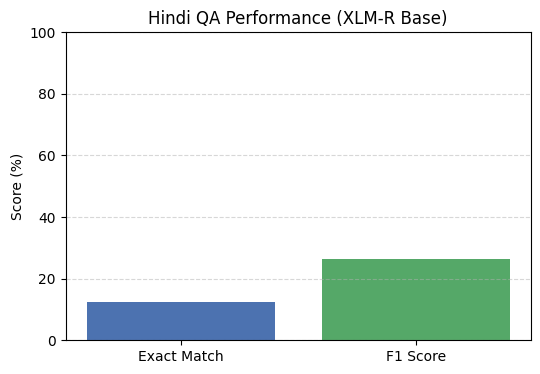

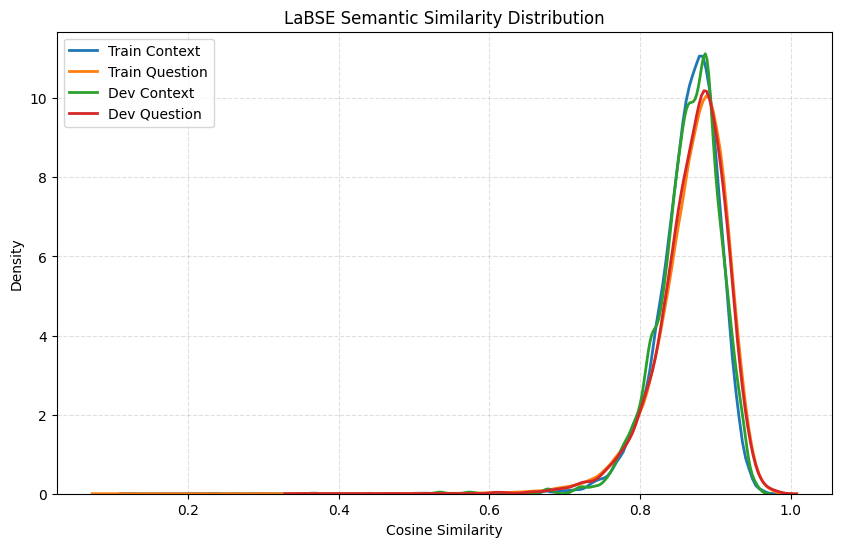

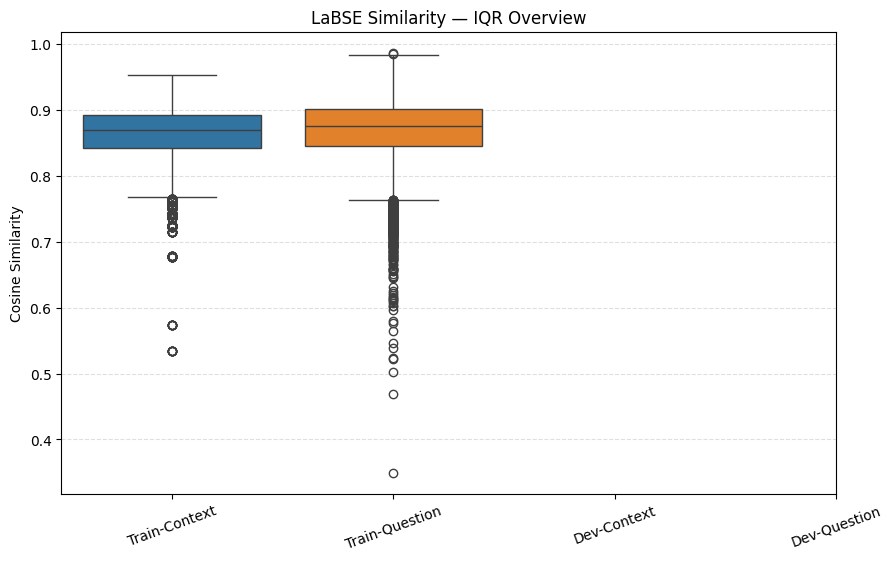

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load your LaBSE output CSVs
train_out = pd.read_csv("/content/drive/MyDrive/msu-nlp/train_with_labse_scores.csv")
dev_out   = pd.read_csv("/content/drive/MyDrive/msu-nlp/dev_with_labse_scores.csv")

# Now extract similarity columns
train_context_sim = train_out["sim_context"]
train_question_sim = train_out["sim_question"]

dev_context_sim = dev_out["sim_context"]
dev_question_sim = dev_out["sim_question"]


# ----------------------------------
# SAMPLE VARIABLES (insert your real results)
# ----------------------------------
train_context_sim = train_out["sim_context"]
train_question_sim = train_out["sim_question"]

dev_context_sim = dev_out["sim_context"]
dev_question_sim = dev_out["sim_question"]

em_score = 12.30
f1_score = 26.55

# --------------------------------------------
# 1) BAR CHART — Hindi XLM-R QA Performance
# --------------------------------------------
plt.figure(figsize=(6,4))
plt.bar(["Exact Match", "F1 Score"], [em_score, f1_score], color=["#4C72B0","#55A868"])
plt.title("Hindi QA Performance (XLM-R Base)")
plt.ylabel("Score (%)")
plt.ylim(0, 100)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


# ------------------------------------------------------------
# 2) KDE DISTRIBUTION — LaBSE Semantic Similarity (Train/Dev)
# ------------------------------------------------------------
plt.figure(figsize=(10,6))
sns.kdeplot(train_context_sim, label="Train Context", linewidth=2)
sns.kdeplot(train_question_sim, label="Train Question", linewidth=2)
sns.kdeplot(dev_context_sim, label="Dev Context", linewidth=2)
sns.kdeplot(dev_question_sim, label="Dev Question", linewidth=2)
plt.title("LaBSE Semantic Similarity Distribution")
plt.xlabel("Cosine Similarity")
plt.ylabel("Density")
plt.grid(linestyle="--", alpha=0.4)
plt.legend()
plt.show()


# --------------------------------------------
# 3) BOXPLOTS — Train vs Dev with IQR Highlight
# --------------------------------------------
plt.figure(figsize=(10,6))
sns.boxplot(data=[
    train_context_sim,
    train_question_sim,
    dev_context_sim,
    dev_question_sim
])
plt.xticks(
    [0,1,2,3],
    ["Train-Context", "Train-Question", "Dev-Context", "Dev-Question"],
    rotation=20
)
plt.title("LaBSE Similarity — IQR Overview")
plt.ylabel("Cosine Similarity")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()


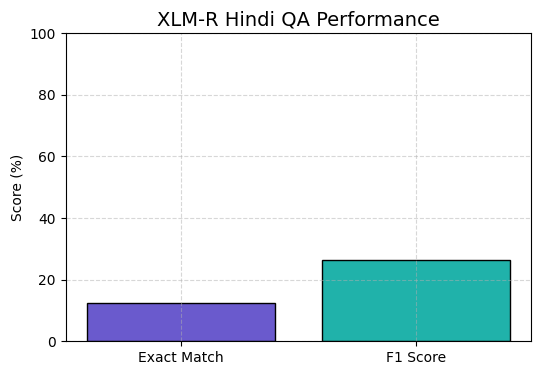

In [55]:
import matplotlib.pyplot as plt

em = 12.30
f1 = 26.55

plt.figure(figsize=(6,4))
plt.bar(["Exact Match", "F1 Score"], [em, f1],
        color=["#6A5ACD","#20B2AA"], edgecolor='black')
plt.title("XLM-R Hindi QA Performance", fontsize=14)
plt.ylabel("Score (%)")
plt.ylim(0, 100)
plt.grid(linestyle="--", alpha=0.5)
plt.show()

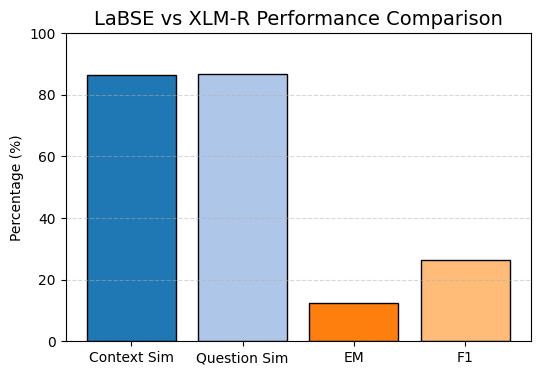

In [56]:
import matplotlib.pyplot as plt

# Averages from your LaBSE results
avg_context_sim = train_context_sim.mean()
avg_question_sim = train_question_sim.mean()

plt.figure(figsize=(6,4))
plt.bar(["Context Sim", "Question Sim", "EM", "F1"],
        [avg_context_sim*100, avg_question_sim*100, em, f1],
        color=["#1f77b4","#aec7e8","#ff7f0e","#ffbb78"],
        edgecolor='black')
plt.title("LaBSE vs XLM-R Performance Comparison", fontsize=14)
plt.ylabel("Percentage (%)")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()